# Simple forecasting techniques

## The importance of a baseline model

In this notebook we will explore some simple forecasting techniques.  Selecting on of these simple techniques should on of your early decisions in a time series forecasting project. Although each represents simple approach to forecasting they are from a family of techniques used for setting a statistical baseline. Before you move onto complex methods make sure you use a benchmark or baseline.  Any complex model must be better than the baseline to be considered for forecasting.  This is a often a missed step in forecasting where there is a temptation to use complex methods.

The methods we will explore are:

* Naive Forecast 1
* Seasonal Naive

We will also briefly introduce **Prediction Intervals** and measuring **forecast error**

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

# forecast-tools

In [2]:
# if running in colab then install forecast-tools
#!pip install forecast-tools

# Help functions

In [3]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    preds - numpy.array, vector of predictions
    start - start date of the time series
    freq - the frequency of the time series e.g 'MS' or 'D'
    '''
    start = pd.date_range(start=data.index.max(), periods=2, freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

# The ED arrivals dataset.

The dataset we will use represent daily adult (age > 18) arrivals to an Emergency Department.  The simulated observations are based on attendences at a real emergency department between Jan 2017 and Dec 2017.

In [4]:
#the url link means you are downloading this data directly from the HSMA github repo.
url = 'https://raw.githubusercontent.com/health-data-science-OR/hpdm097-datasets/master/ed_attends.csv'
ed_daily = pd.read_csv(url, parse_dates=True, index_col='date')
ed_daily.index.freq = 'D'

In [5]:
ed_daily.index.min()

Timestamp('2017-01-22 00:00:00')

In [6]:
ed_daily.index.max()

Timestamp('2017-12-31 00:00:00')

In [7]:
ed_daily.shape

(344, 1)

### Visualise the time series

<Axes: xlabel='date'>

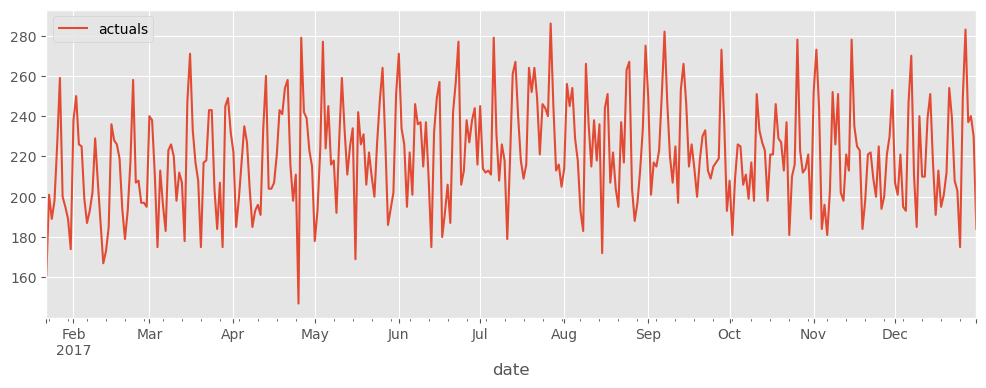

In [8]:
ed_daily.plot(figsize=(12,4))

# Naive Forecast 1

An alternative and popular baseline forecast is Naive Forecast 1.  This simply takes the last value in the time series and extrapolates it forward over the forecast horizon.  I.e.

**Naive Forecast = Last value in the time series**

In mathematical notation:

$\hat{y}_{T+h|T} =y_t$

PenCHORD has implemented some simple classes for baseline forecasts in a package called `forecast-tools`.  

For a Naive 1 forecast the class to use is

```python
forecast_tools.baseline.Naive1
```

There are three steps to use it

* Create an instance of the class
* Call the `fit` method and pass in the historical data
* Call the `predict` method and pass in a chosen forecast horizon e.g. 28 days. 

In [9]:
from forecast_tools.baseline import Naive1

In [10]:
nf1 = Naive1()
nf1.fit(ed_daily)
nf1_preds = nf1.predict(horizon=28)

In [11]:
nf1_preds

array([184., 184., 184., 184., 184., 184., 184., 184., 184., 184., 184.,
       184., 184., 184., 184., 184., 184., 184., 184., 184., 184., 184.,
       184., 184., 184., 184., 184., 184.])

Let's visualise the forecast relative to the training data.

* Do you think this is a good baseline?

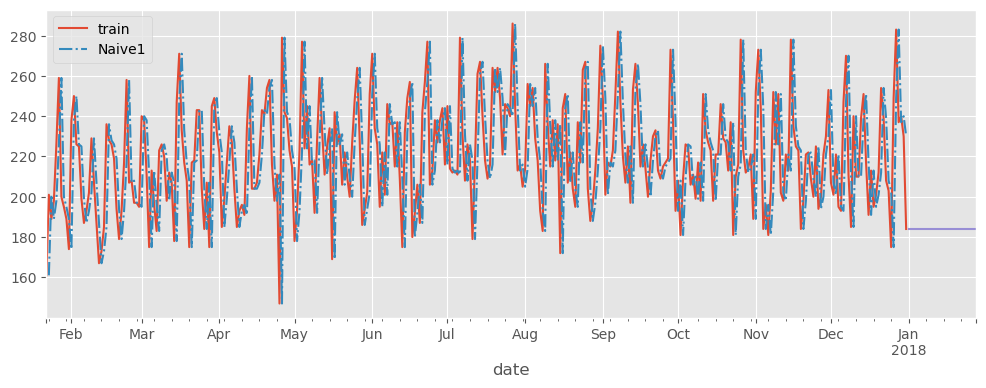

In [12]:
ax = ed_daily.plot(figsize=(12,4))
nf1.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(ed_daily, nf1_preds).plot(ax=ax)
ax.legend(['train', 'Naive1'])

## Seasonal Naive

Seasonal Naive extends Naive1 in an attempt to incorporate the seasonality in the data.  Instead of carrying the final value in the time series forward it carries forward the value from the previous time period.  As we are working with monthly data this means that a forecast for Janurary will use the previous Janurary's observation. A forecast for February will use the previous February's observation and so on.

In [13]:
from forecast_tools.baseline import SNaive

In [14]:
snf = SNaive(period=7)
snf.fit(ed_daily)
snf_preds = snf.predict(horizon=28)

In [15]:
snf_preds

array([175., 249., 283., 237., 240., 230., 184., 175., 249., 283., 237.,
       240., 230., 184., 175., 249., 283., 237., 240., 230., 184., 175.,
       249., 283., 237., 240., 230., 184.])

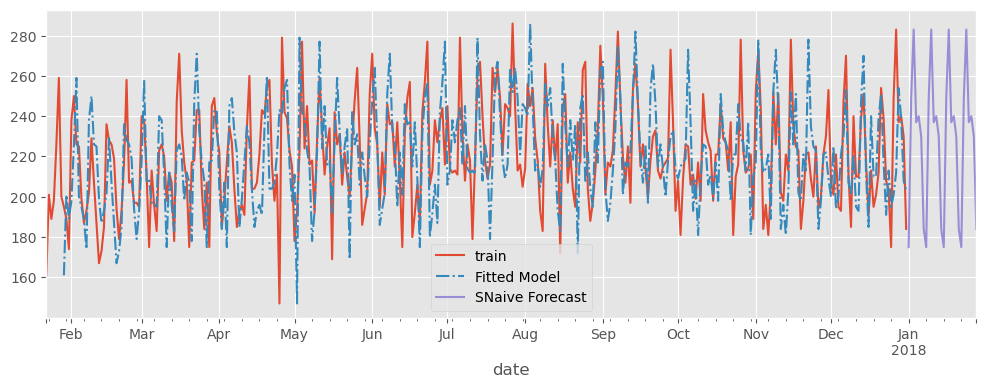

In [16]:
ax = ed_daily.plot(figsize=(12,4))
snf.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(ed_daily, snf_preds).plot(ax=ax)
ax.legend(['train','Fitted Model', 'SNaive Forecast'])

## Prediction Intervals

To return a prediction interval from a baseline forecast object use:

```python
y_preds, y_intervals = model.predict(horizon, return_predict_int=True)
```

By default this returns 80% and 90% PIs.  

To return only the 80% intervals use:

```python
y_preds, y_intervals = model.predict(horizon, 
                                     return_predict_int=True, 
                                     alpha=[0.2])
```

To return, the 80, 90 and 95% intervals use:


```python
y_preds, y_intervals = model.predict(horizon, 
                                     return_predict_int=True, 
                                     alpha=[0.2,0.1,0.05])
```

In [17]:
snf = SNaive(period=7)
snf.fit(ed_daily)
y_preds, y_intervals = snf.predict(horizon=6, return_predict_int=True, 
                                    alpha=[0.2, 0.05])
y_intervals[1]

array([[127.4295279, 222.5704721],
       [201.4295279, 296.5704721],
       [235.4295279, 330.5704721],
       [189.4295279, 284.5704721],
       [192.4295279, 287.5704721],
       [182.4295279, 277.5704721]])

In [18]:
def plot_prediction_intervals(train, preds, intervals, test=None):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    ax = train.plot(figsize=(12,4))

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                   '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', '_ignore',
                   '_ignore', '90%PI'], loc=2)
    
    

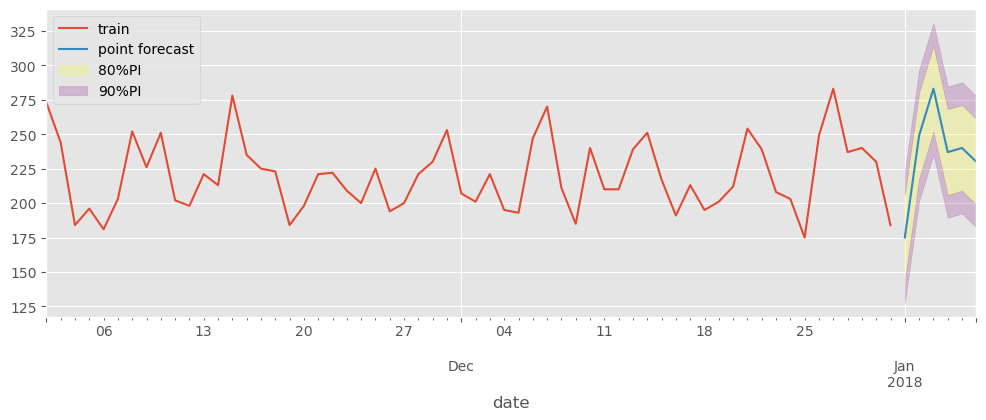

In [19]:
plot_prediction_intervals(ed_daily[-60:], y_preds, y_intervals)

# Measuring Point Forecast Error.

## A basic train test split

Let's hold back 28 days of data and calculate the forecast error of Seasonal Naive.

`forecast-tools` helps you calculate forecast error with the `forecast_tools.metrics.forecast_errors` function.  The function calculates a range of metrics.

In [20]:
train_length = ed_daily.shape[0] - 28
train, test = ed_daily.iloc[:train_length], ed_daily.iloc[train_length:]

In [21]:
train.shape

(316, 1)

In [22]:
test.shape

(28, 1)

### IMPORTANT - DO NOT LOOK AT THE TEST SET!

We need to **hold back** a proportion of our data.  This is so we can simulate real forecasting conditions and check a models accuracy on **unseen** data.  We don't want to know what it looks like as that will introduce bias into the forecasting process and mean we overfit our model to the data we hold.

**Remember - there is no such thing as real time data from the future!**

In [23]:
snf = SNaive(period=7)
preds = snf.fit_predict(train, horizon=28)
preds

array([200., 221., 230., 253., 207., 201., 221., 200., 221., 230., 253.,
       207., 201., 221., 200., 221., 230., 253., 207., 201., 221., 200.,
       221., 230., 253., 207., 201., 221.])

In [24]:
from forecast_tools.metrics import forecast_errors

forecast_errors(test, preds)

{'me': 1.7857142857142858,
 'mae': 26.3265306122449,
 'mse': 1041.357142857143,
 'rmse': 32.27006573989497,
 'mape': 11.909528654313558,
 'smape': 11.848458106338708}

In [25]:
nf1 = Naive1()
preds = nf1.fit_predict(train, horizon=28)
preds

array([221., 221., 221., 221., 221., 221., 221., 221., 221., 221., 221.,
       221., 221., 221., 221., 221., 221., 221., 221., 221., 221., 221.,
       221., 221., 221., 221., 221., 221.])

In [26]:
forecast_errors(test, preds)

{'me': -0.21428571428571427,
 'mae': 23.571428571428573,
 'mse': 736.2142857142857,
 'rmse': 27.133268983192675,
 'mape': 10.756944148491328,
 'smape': 10.64918579718156}